In [ ]:
!pip install joblib

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from joblib import Parallel, delayed
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from scipy.optimize import fsolve
from PySDM_examples.Loftus_and_Wordsworth_2021 import Settings
from PySDM_examples.Loftus_and_Wordsworth_2021.planet import (
    Planet,
    EarthLike,
    Earth,
    EarlyMars,
    Jupiter,
    Saturn,
    K2_18B,
)
from PySDM_examples.Loftus_and_Wordsworth_2021 import Simulation

In [3]:
formulae = Formulae(
    ventilation="PruppacherAndRasmussen1979",
    saturation_vapour_pressure="AugustRocheMagnus",
    diffusion_coordinate="WaterMassLogarithm",
)

In [4]:
new_Earth = EarthLike()
new_Earth.T_STP

300.0

In [5]:
radius_array = np.logspace(-4.5, -2.5, 50) * si.m
RH_array = np.linspace(0.25, 0.99, 50)
output_matrix = np.full((len(RH_array), len(radius_array)), np.nan)
const = formulae.constants


@njit()
def mix(dry, vap, ratio):
    return (dry + ratio * vap) / (1 + ratio)


def compute_one_RH(i, RH):
    """
    Compute one row of the output_matrix for a given RH.
    Returns a 1D numpy array of length len(radius_array).
    """
    new_Earth.RH_zref = RH

    pvs = formulae.saturation_vapour_pressure.pvs_water(new_Earth.T_STP)
    initial_water_vapour_mixing_ratio = const.eps / (
        new_Earth.p_STP / new_Earth.RH_zref / pvs - 1
    )

    Rair = mix(const.Rd, const.Rv, initial_water_vapour_mixing_ratio)
    c_p = mix(const.c_pd, const.c_pv, initial_water_vapour_mixing_ratio)

    def f(x):
        return initial_water_vapour_mixing_ratio / (
            initial_water_vapour_mixing_ratio + const.eps
        ) * new_Earth.p_STP * (x / new_Earth.T_STP) ** (
            c_p / Rair
        ) - formulae.saturation_vapour_pressure.pvs_water(x)

    tdews = fsolve(f, [150, 300])
    Tcloud = np.max(tdews)
    Zcloud = (new_Earth.T_STP - Tcloud) * c_p / new_Earth.g_std
    thstd = formulae.trivia.th_std(new_Earth.p_STP, new_Earth.T_STP)

    pcloud = formulae.hydrostatics.p_of_z_assuming_const_th_and_initial_water_vapour_mixing_ratio(
        new_Earth.p_STP, thstd, initial_water_vapour_mixing_ratio, Zcloud
    )

    np.testing.assert_approx_equal(
        actual=pcloud
        * (
            initial_water_vapour_mixing_ratio
            / (initial_water_vapour_mixing_ratio + const.eps)
        )
        / formulae.saturation_vapour_pressure.pvs_water(Tcloud),
        desired=1,
        significant=4,
    )

    output = None
    row_data = np.full(len(radius_array), np.nan)
    for j, r in enumerate(radius_array[::-1]):
        settings = Settings(
            planet=new_Earth,
            r_wet=r,
            mass_of_dry_air=1e5 * si.kg,
            initial_water_vapour_mixing_ratio=initial_water_vapour_mixing_ratio,
            pcloud=pcloud,
            Zcloud=Zcloud,
            Tcloud=Tcloud,
            formulae=formulae,
        )
        simulation = Simulation(settings)
        try:
            output = simulation.run()
            if output["z"][-1] > 0:
                row_data[j] = np.nan
                break
            else:
                row_data[j] = 1 - (output["r"][-1] / (r * 1e6))
        except Exception as _:
            break

    return i, row_data, output

In [6]:
all_rows = Parallel(n_jobs=os.cpu_count())(
    delayed(compute_one_RH)(i, RH) for i, RH in enumerate(RH_array[::-1])
)

last_output = None
for i, row_data, output in all_rows:
    output_matrix[i] = row_data
    last_output = output

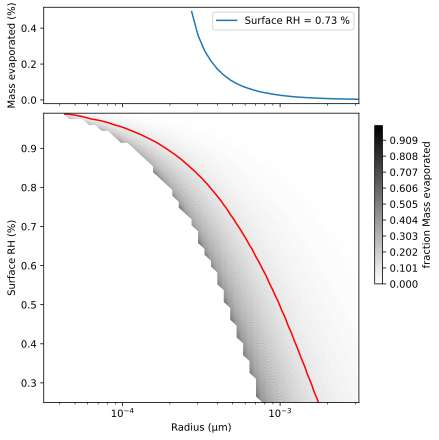

In [7]:
row_data = output_matrix[18, ::-1]  # Reverse the row for plotting
fig, ax = plt.subplots(
    2,
    1,
    figsize=(6, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 3]},
    constrained_layout=True,
)
ax[0].plot(radius_array, row_data, label=f"Surface RH = {RH_array[-18]:.2f} %")
ax[0].set_ylabel("Mass evaporated (%)")
ax[0].legend()

h = ax[1].contourf(
    radius_array,
    RH_array[::-1],
    output_matrix[:, ::-1],
    cmap="gray_r",
    levels=np.linspace(0, 1, 100),
)
ax[1].set_xscale("log")

# Add labels
ax[1].set_xlabel("Radius (µm)")
ax[1].set_ylabel("Surface RH (%)")

cbar = fig.colorbar(h, ax=ax, shrink=0.4)
cbar.set_label("fraction Mass evaporated")
contour_levels = [0.1]  # Define the level for the contour
ax[1].contour(
    radius_array,
    RH_array[::-1],
    output_matrix[:, ::-1],
    levels=contour_levels,
    colors="red",
    linewidths=1.5,
)
show_plot()

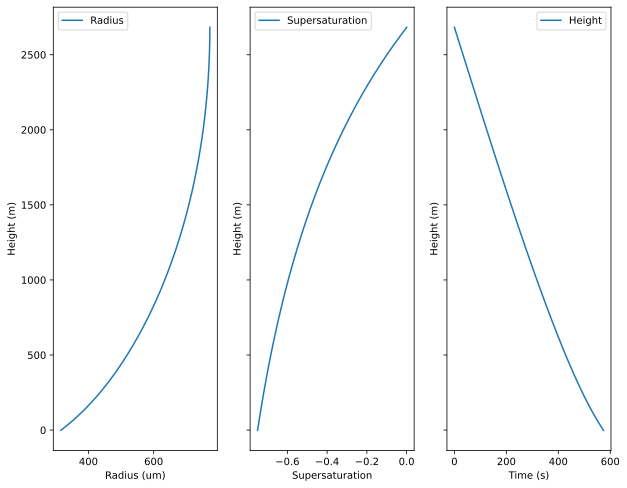

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8), sharey=True)
axs[0].plot(last_output["r"], last_output["z"], label="Radius")
axs[0].set_ylabel("Height (m)")
axs[0].set_xlabel("Radius (um)")
axs[0].legend()
axs[1].plot(last_output["S"], last_output["z"], label="Supersaturation")
axs[1].set_xlabel("Supersaturation")
axs[1].set_ylabel("Height (m)")
axs[1].legend()
axs[2].plot(last_output["t"], last_output["z"], label="Height")
axs[2].set_ylabel("Height (m)")
axs[2].set_xlabel("Time (s)")
axs[2].legend()
show_plot()